In [1]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/Dataset', output="output", seed=1337, ratio=(.8, .2), group_prefix=None)

Copying files: 55449 files [12:36, 73.26 files/s] 


In [4]:
import numpy as np
from re import sub
import tensorflow as tf
from tensorflow.keras import metrics

import matplotlib.colors as mcolors
from sklearn.metrics import confusion_matrix
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

In [6]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

# ***Using InceptionV3 CNN architecture***

In [7]:

from tensorflow.keras.applications.inception_v3 import preprocess_input

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator=train_datagen.flow_from_directory('./output/train',
                                                 target_size=IMG_SIZE,
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
                                                 shuffle=True)

val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator=train_datagen.flow_from_directory('./output/val',
                                                     target_size=IMG_SIZE,
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 44343 images belonging to 39 classes.
Found 11106 images belonging to 39 classes.


In [8]:
classes = train_generator.class_indices
class_list = list(classes.keys())

In [9]:
base_model=tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, weights='imagenet',include_top=False)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
preds=Dense(39,activation='softmax')(x)

87910968/87910968 [==============================] - 3s 0us/step


In [10]:
model=Model(inputs=base_model.input,outputs=preds)

In [11]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [12]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=METRICS)

In [13]:
step_size_train=train_generator.n//train_generator.batch_size
model_history=model.fit(train_generator,
                    validation_data =val_generator,
                   steps_per_epoch=step_size_train,
                   epochs=5)

Epoch 1/5
1385/1385 [==============================] - 371s 227ms/step - loss: 0.7013 - tp: 32938.0000 - fp: 4206.0000 - tn: 1679612.0000 - fn: 11373.0000 - accuracy: 0.7979 - precision: 0.8868 - recall: 0.7433 - auc: 0.9866 - val_loss: 1.8004 - val_tp: 6793.0000 - val_fp: 3103.0000 - val_tn: 418925.0000 - val_fn: 4313.0000 - val_accuracy: 0.6544 - val_precision: 0.6864 - val_recall: 0.6117 - val_auc: 0.9269
Epoch 2/5
1385/1385 [==============================] - 303s 219ms/step - loss: 0.2427 - tp: 40440.0000 - fp: 2452.0000 - tn: 1681366.0000 - fn: 3871.0000 - accuracy: 0.9266 - precision: 0.9428 - recall: 0.9126 - auc: 0.9964 - val_loss: 0.9122 - val_tp: 8733.0000 - val_fp: 1760.0000 - val_tn: 420268.0000 - val_fn: 2373.0000 - val_accuracy: 0.8088 - val_precision: 0.8323 - val_recall: 0.7863 - val_auc: 0.9750
Epoch 3/5
1385/1385 [==============================] - 312s 225ms/step - loss: 0.1795 - tp: 41548.0000 - fp: 1873.0000 - tn: 1681945.0000 - fn: 2763.0000 - accuracy: 0.9472 - pr

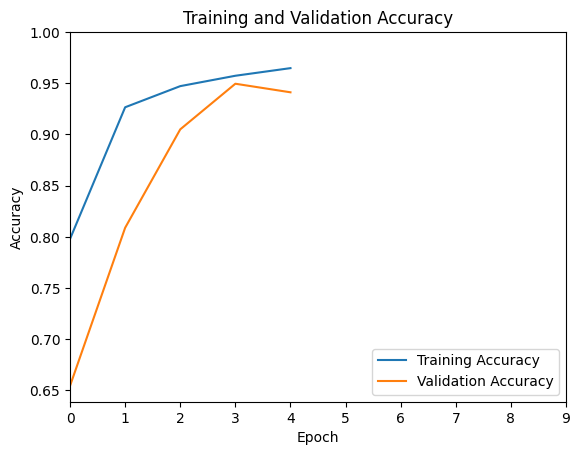

<Figure size 640x480 with 0 Axes>

In [14]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlim([0,9])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.show()
plt.savefig("model_Accuracy.png")

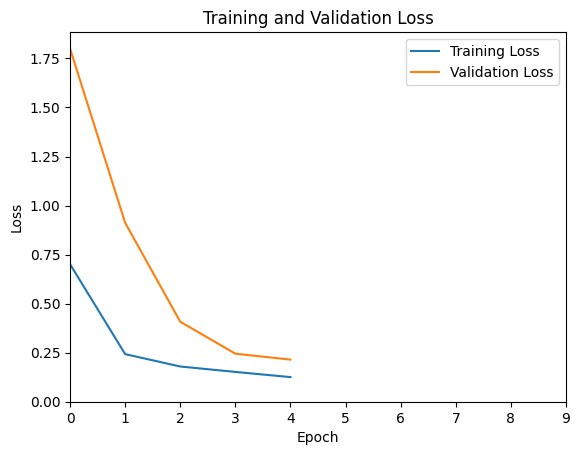

<Figure size 640x480 with 0 Axes>

In [15]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlim([0,9])
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()
plt.savefig("model_Loss.png")

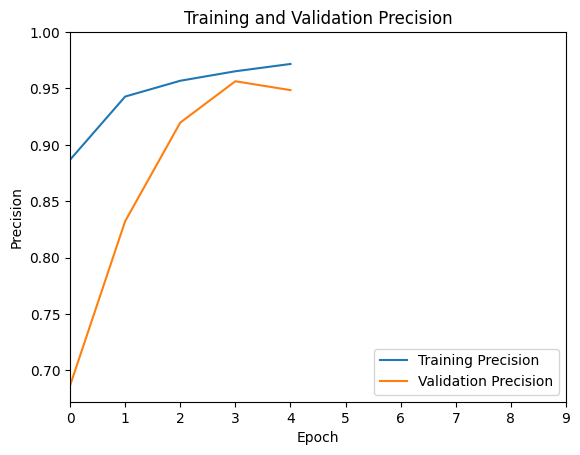

<Figure size 640x480 with 0 Axes>

In [16]:
pre = model_history.history['precision']
val_pre = model_history.history['val_precision']

plt.plot(pre, label='Training Precision')
plt.plot(val_pre, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel("Precision")
plt.xlim([0,9])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.show()
plt.savefig("model_Precision.png")

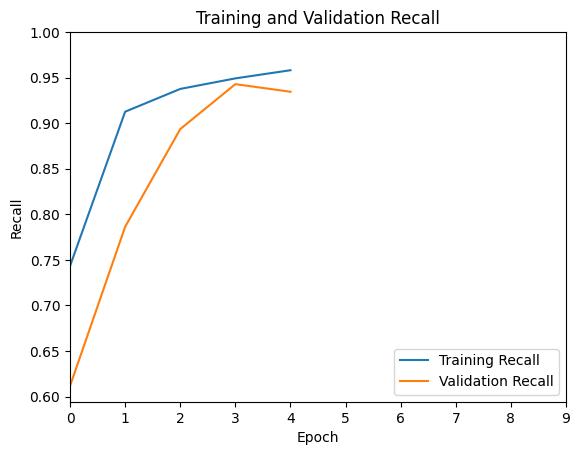

<Figure size 640x480 with 0 Axes>

In [17]:
rec = model_history.history['recall']
val_rec = model_history.history['val_recall']

plt.plot(rec, label='Training Recall')
plt.plot(val_rec, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel("Recall")
plt.xlim([0,9])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.show()
plt.savefig("model_Recall.png")

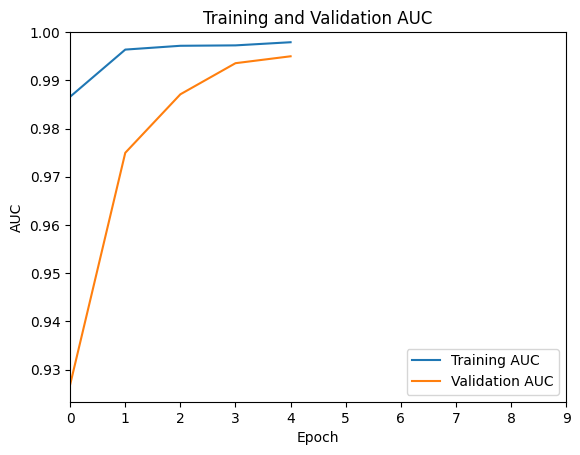

<Figure size 640x480 with 0 Axes>

In [18]:
auc = model_history.history['auc']
val_auc = model_history.history['val_auc']

plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.ylabel("AUC")
plt.xlim([0,9])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.show()
plt.savefig("model_Auc.png")

348/348 [==============================] - 37s 100ms/step


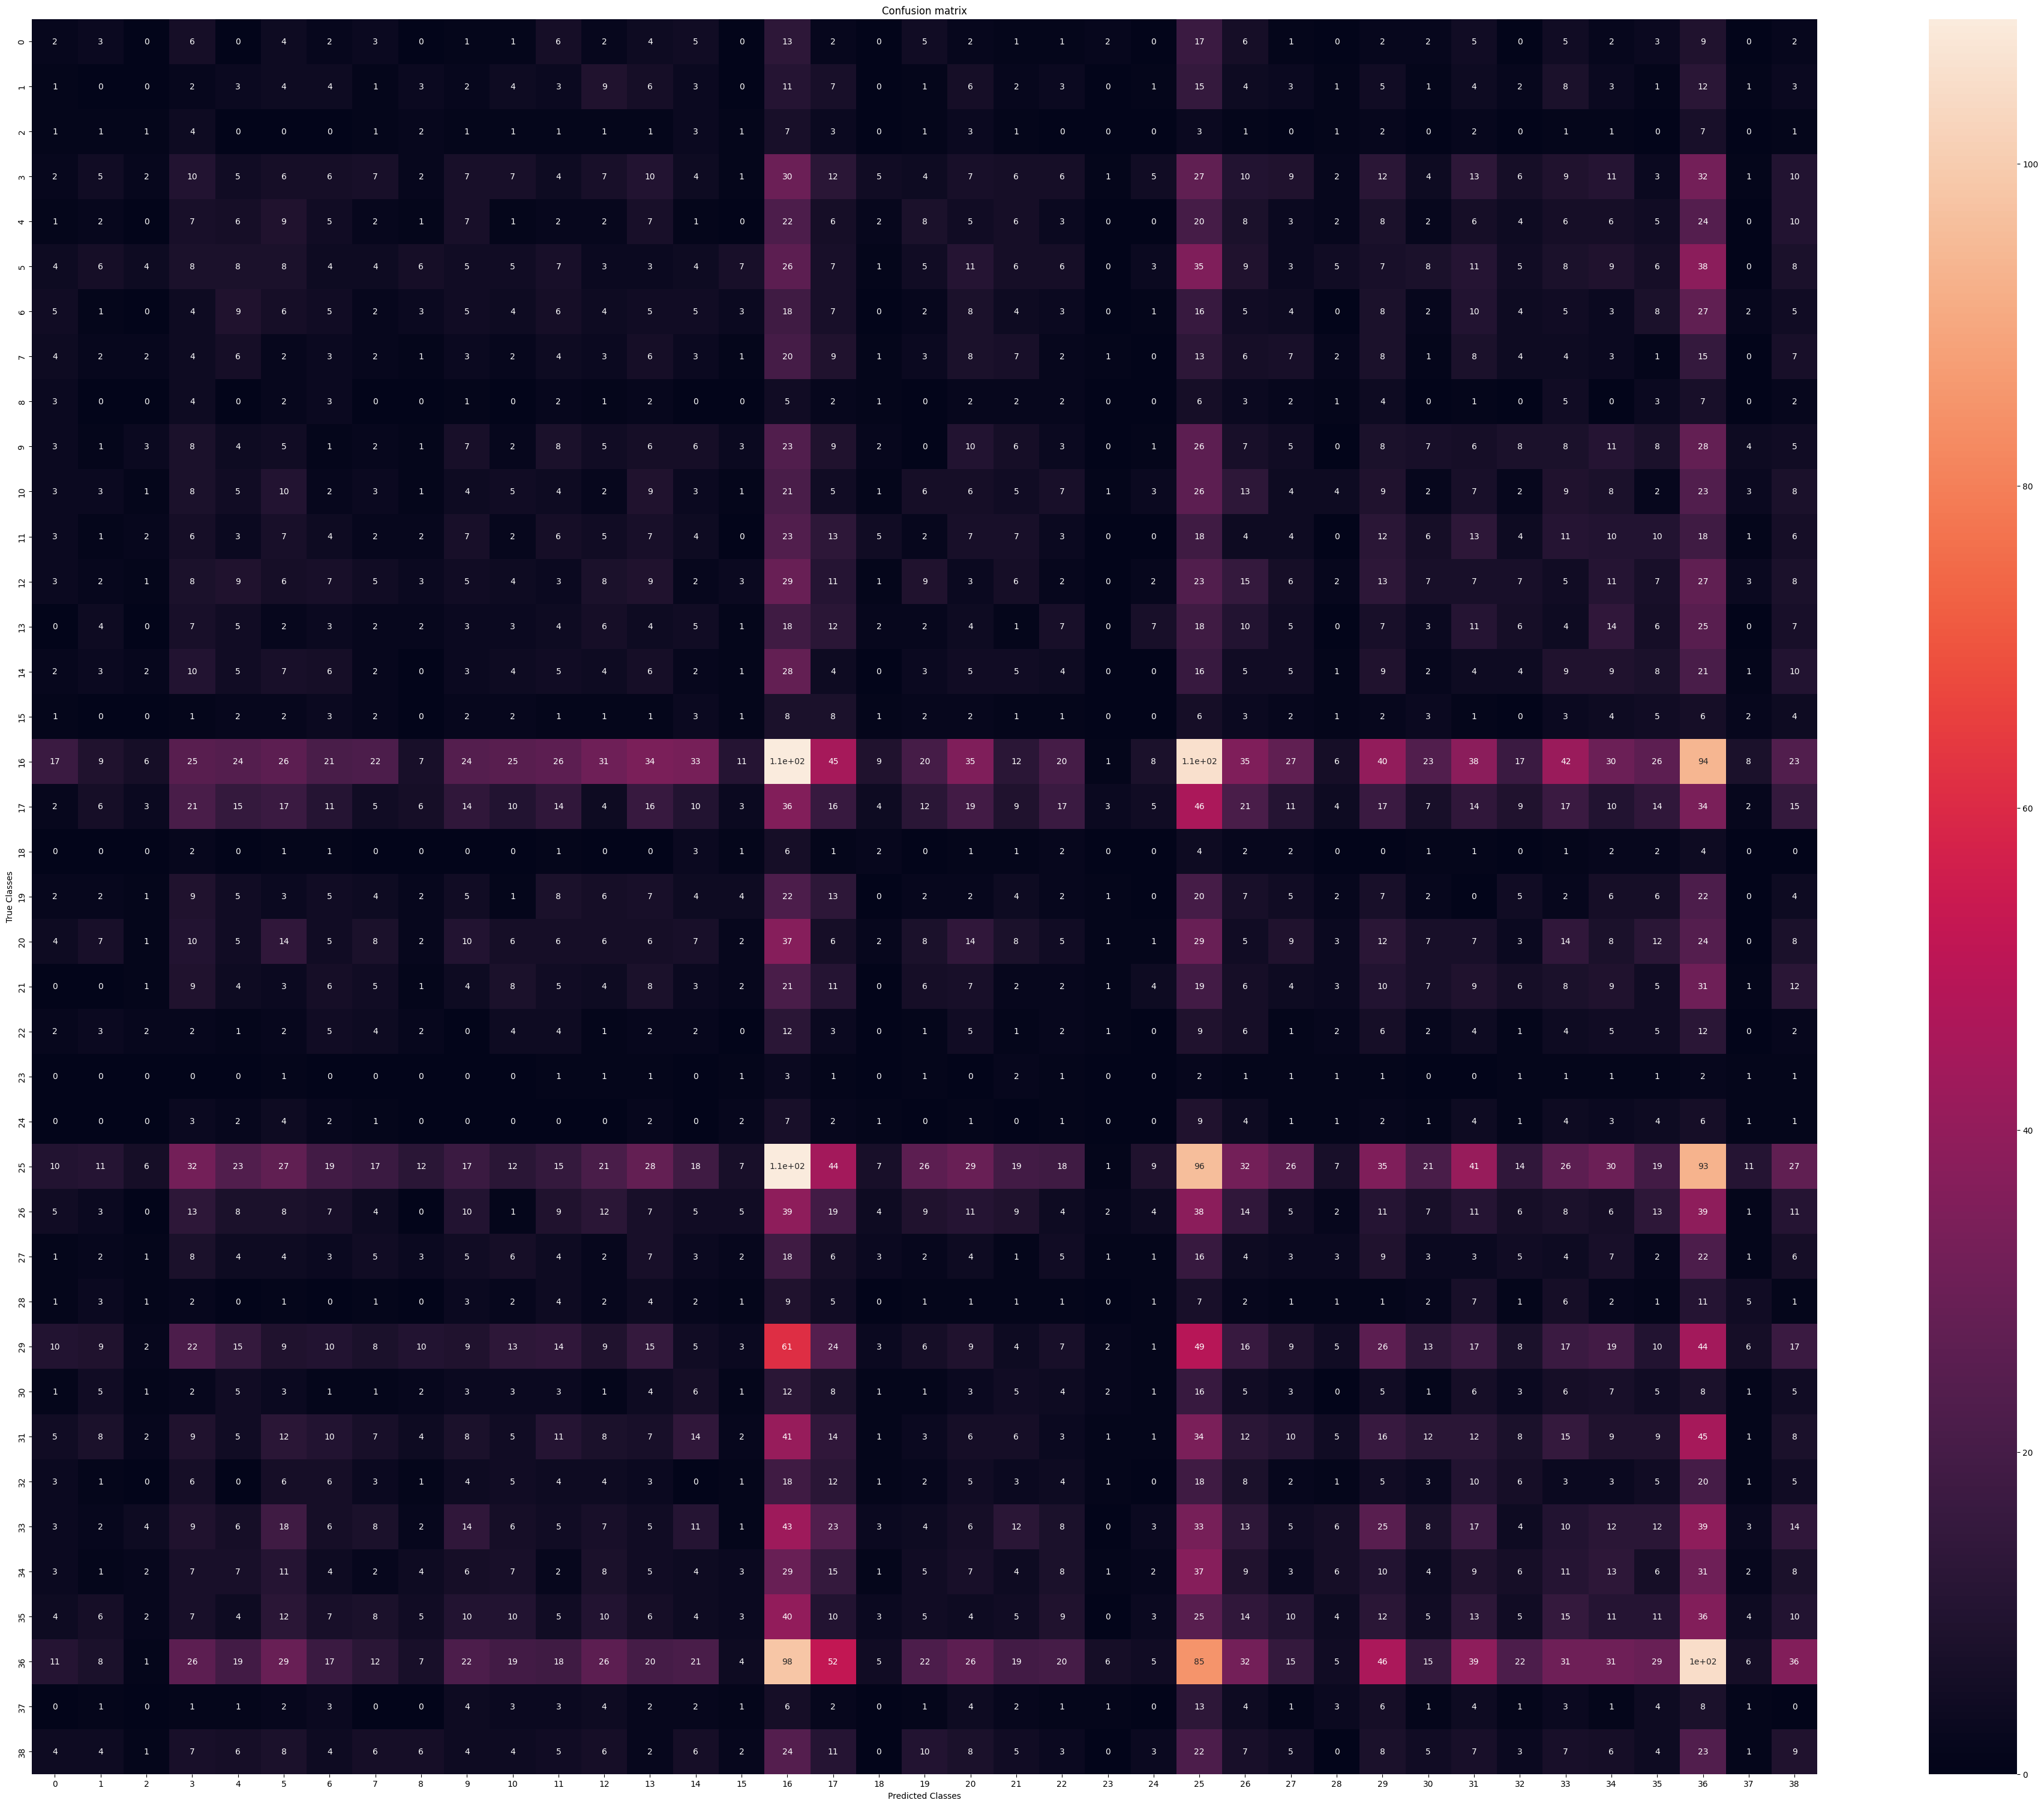

In [19]:
p = model.predict(val_generator)
p = np.argmax(p, axis=1)
y_true = val_generator.classes
c = confusion_matrix(p, y_true)

plt.figure(figsize=(48,38))
plt.title('Confusion matrix')
sns.heatmap(c, annot=True)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.plot()
plt.savefig("model_Confusion_matrix.png")

In [20]:
model.save("InceptionV3.h5")

# ***Using InceptionResNetV2 CNN architecture***

In [21]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator=train_datagen.flow_from_directory('./output/train',
                                                 target_size=IMG_SIZE,
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
                                                 shuffle=True)

val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator=train_datagen.flow_from_directory('./output/val',
                                                     target_size=IMG_SIZE,
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 44343 images belonging to 39 classes.
Found 11106 images belonging to 39 classes.


In [22]:
base_model=tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE, weights='imagenet',include_top=False)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
preds=Dense(39,activation='softmax')(x)

219055592/219055592 [==============================] - 8s 0us/step


In [23]:
model1=Model(inputs=base_model.input,outputs=preds)

In [24]:
for layer in model1.layers[:20]:
    layer.trainable=False
for layer in model1.layers[20:]:
    layer.trainable=True

In [25]:
model1.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=METRICS)

In [26]:
step_size_train=train_generator.n//train_generator.batch_size
model1_history=model1.fit(train_generator,
                    validation_data =val_generator,
                   steps_per_epoch=step_size_train,
                   epochs=5)

Epoch 1/5
1385/1385 [==============================] - 898s 573ms/step - loss: 0.4223 - tp: 47800.0000 - fp: 3644.0000 - tn: 2102202.0000 - fn: 7617.0000 - accuracy: 0.8889 - precision: 0.9292 - recall: 0.8626 - auc: 0.9938 - val_loss: 0.6192 - val_tp: 9350.0000 - val_fp: 1282.0000 - val_tn: 420746.0000 - val_fn: 1756.0000 - val_accuracy: 0.8566 - val_precision: 0.8794 - val_recall: 0.8419 - val_auc: 0.9817
Epoch 2/5
1385/1385 [==============================] - 762s 550ms/step - loss: 0.1496 - tp: 42086.0000 - fp: 1495.0000 - tn: 1682323.0000 - fn: 2225.0000 - accuracy: 0.9577 - precision: 0.9657 - recall: 0.9498 - auc: 0.9975 - val_loss: 1.2461 - val_tp: 9353.0000 - val_fp: 1266.0000 - val_tn: 420762.0000 - val_fn: 1753.0000 - val_accuracy: 0.8580 - val_precision: 0.8808 - val_recall: 0.8422 - val_auc: 0.9670
Epoch 3/5
1385/1385 [==============================] - 761s 549ms/step - loss: 0.1163 - tp: 42671.0000 - fp: 1136.0000 - tn: 1682682.0000 - fn: 1640.0000 - accuracy: 0.9683 - pre

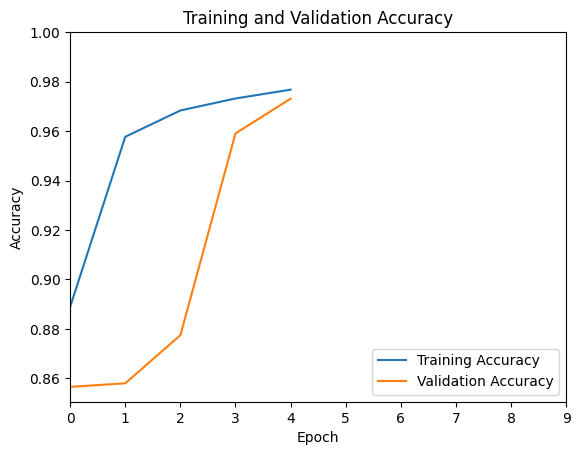

<Figure size 640x480 with 0 Axes>

In [47]:
acc = model1_history.history['accuracy']
val_acc = model1_history.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlim([0,9])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.show()
plt.savefig("model1_Accuracy.png")

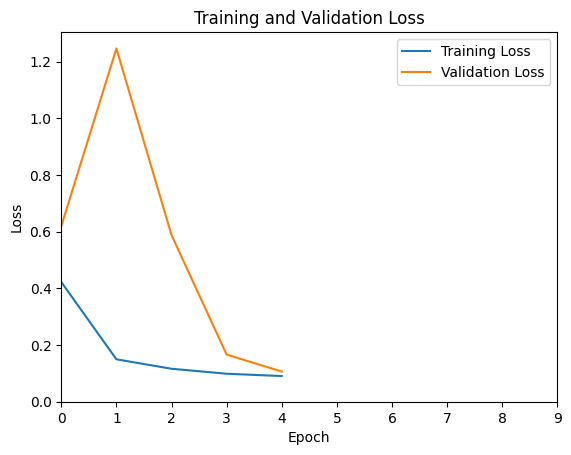

<Figure size 640x480 with 0 Axes>

In [48]:
loss = model1_history.history['loss']
val_loss = model1_history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlim([0,9])
plt.ylim([0,plt.ylim()[1]])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()
plt.savefig("model1_Loss.png")

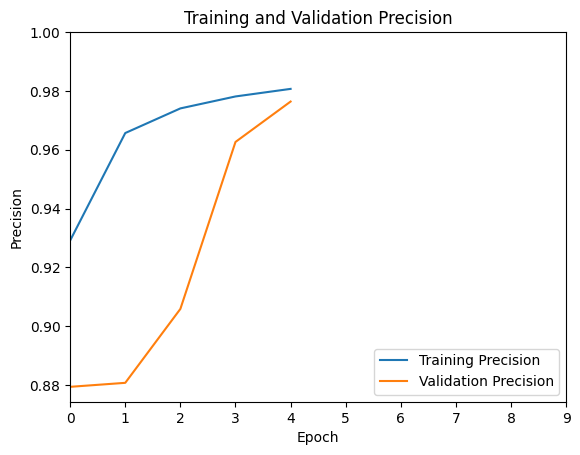

<Figure size 640x480 with 0 Axes>

In [49]:
pre = model1_history.history['precision']
val_pre = model1_history.history['val_precision']

plt.plot(pre, label='Training Precision')
plt.plot(val_pre, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel("Precision")
plt.xlim([0,9])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.show()
plt.savefig("model1_Precision.png")

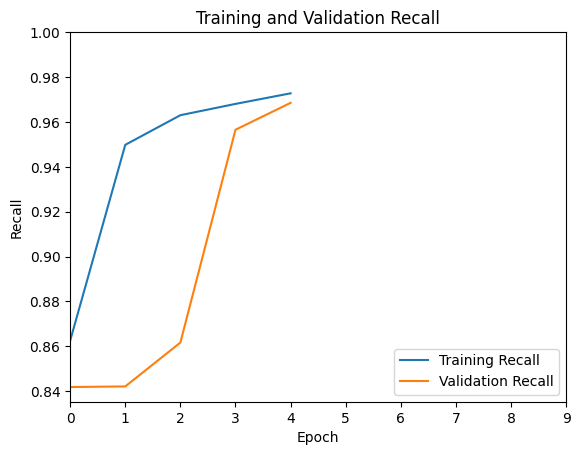

<Figure size 640x480 with 0 Axes>

In [50]:
rec = model1_history.history['recall']
val_rec = model1_history.history['val_recall']

plt.plot(rec, label='Training Recall')
plt.plot(val_rec, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel("Recall")
plt.xlim([0,9])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.show()
plt.savefig("model1_Recall.png")

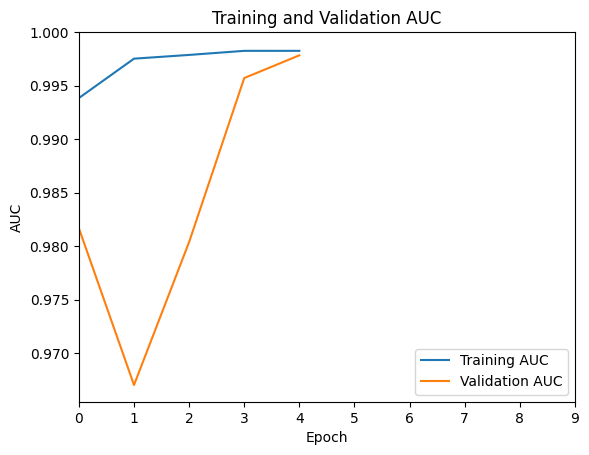

<Figure size 640x480 with 0 Axes>

In [51]:
auc = model1_history.history['auc']
val_auc = model1_history.history['val_auc']

plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.ylabel("AUC")
plt.xlim([0,9])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.show()
plt.savefig("model1_Auc.png")

348/348 [==============================] - 60s 171ms/step


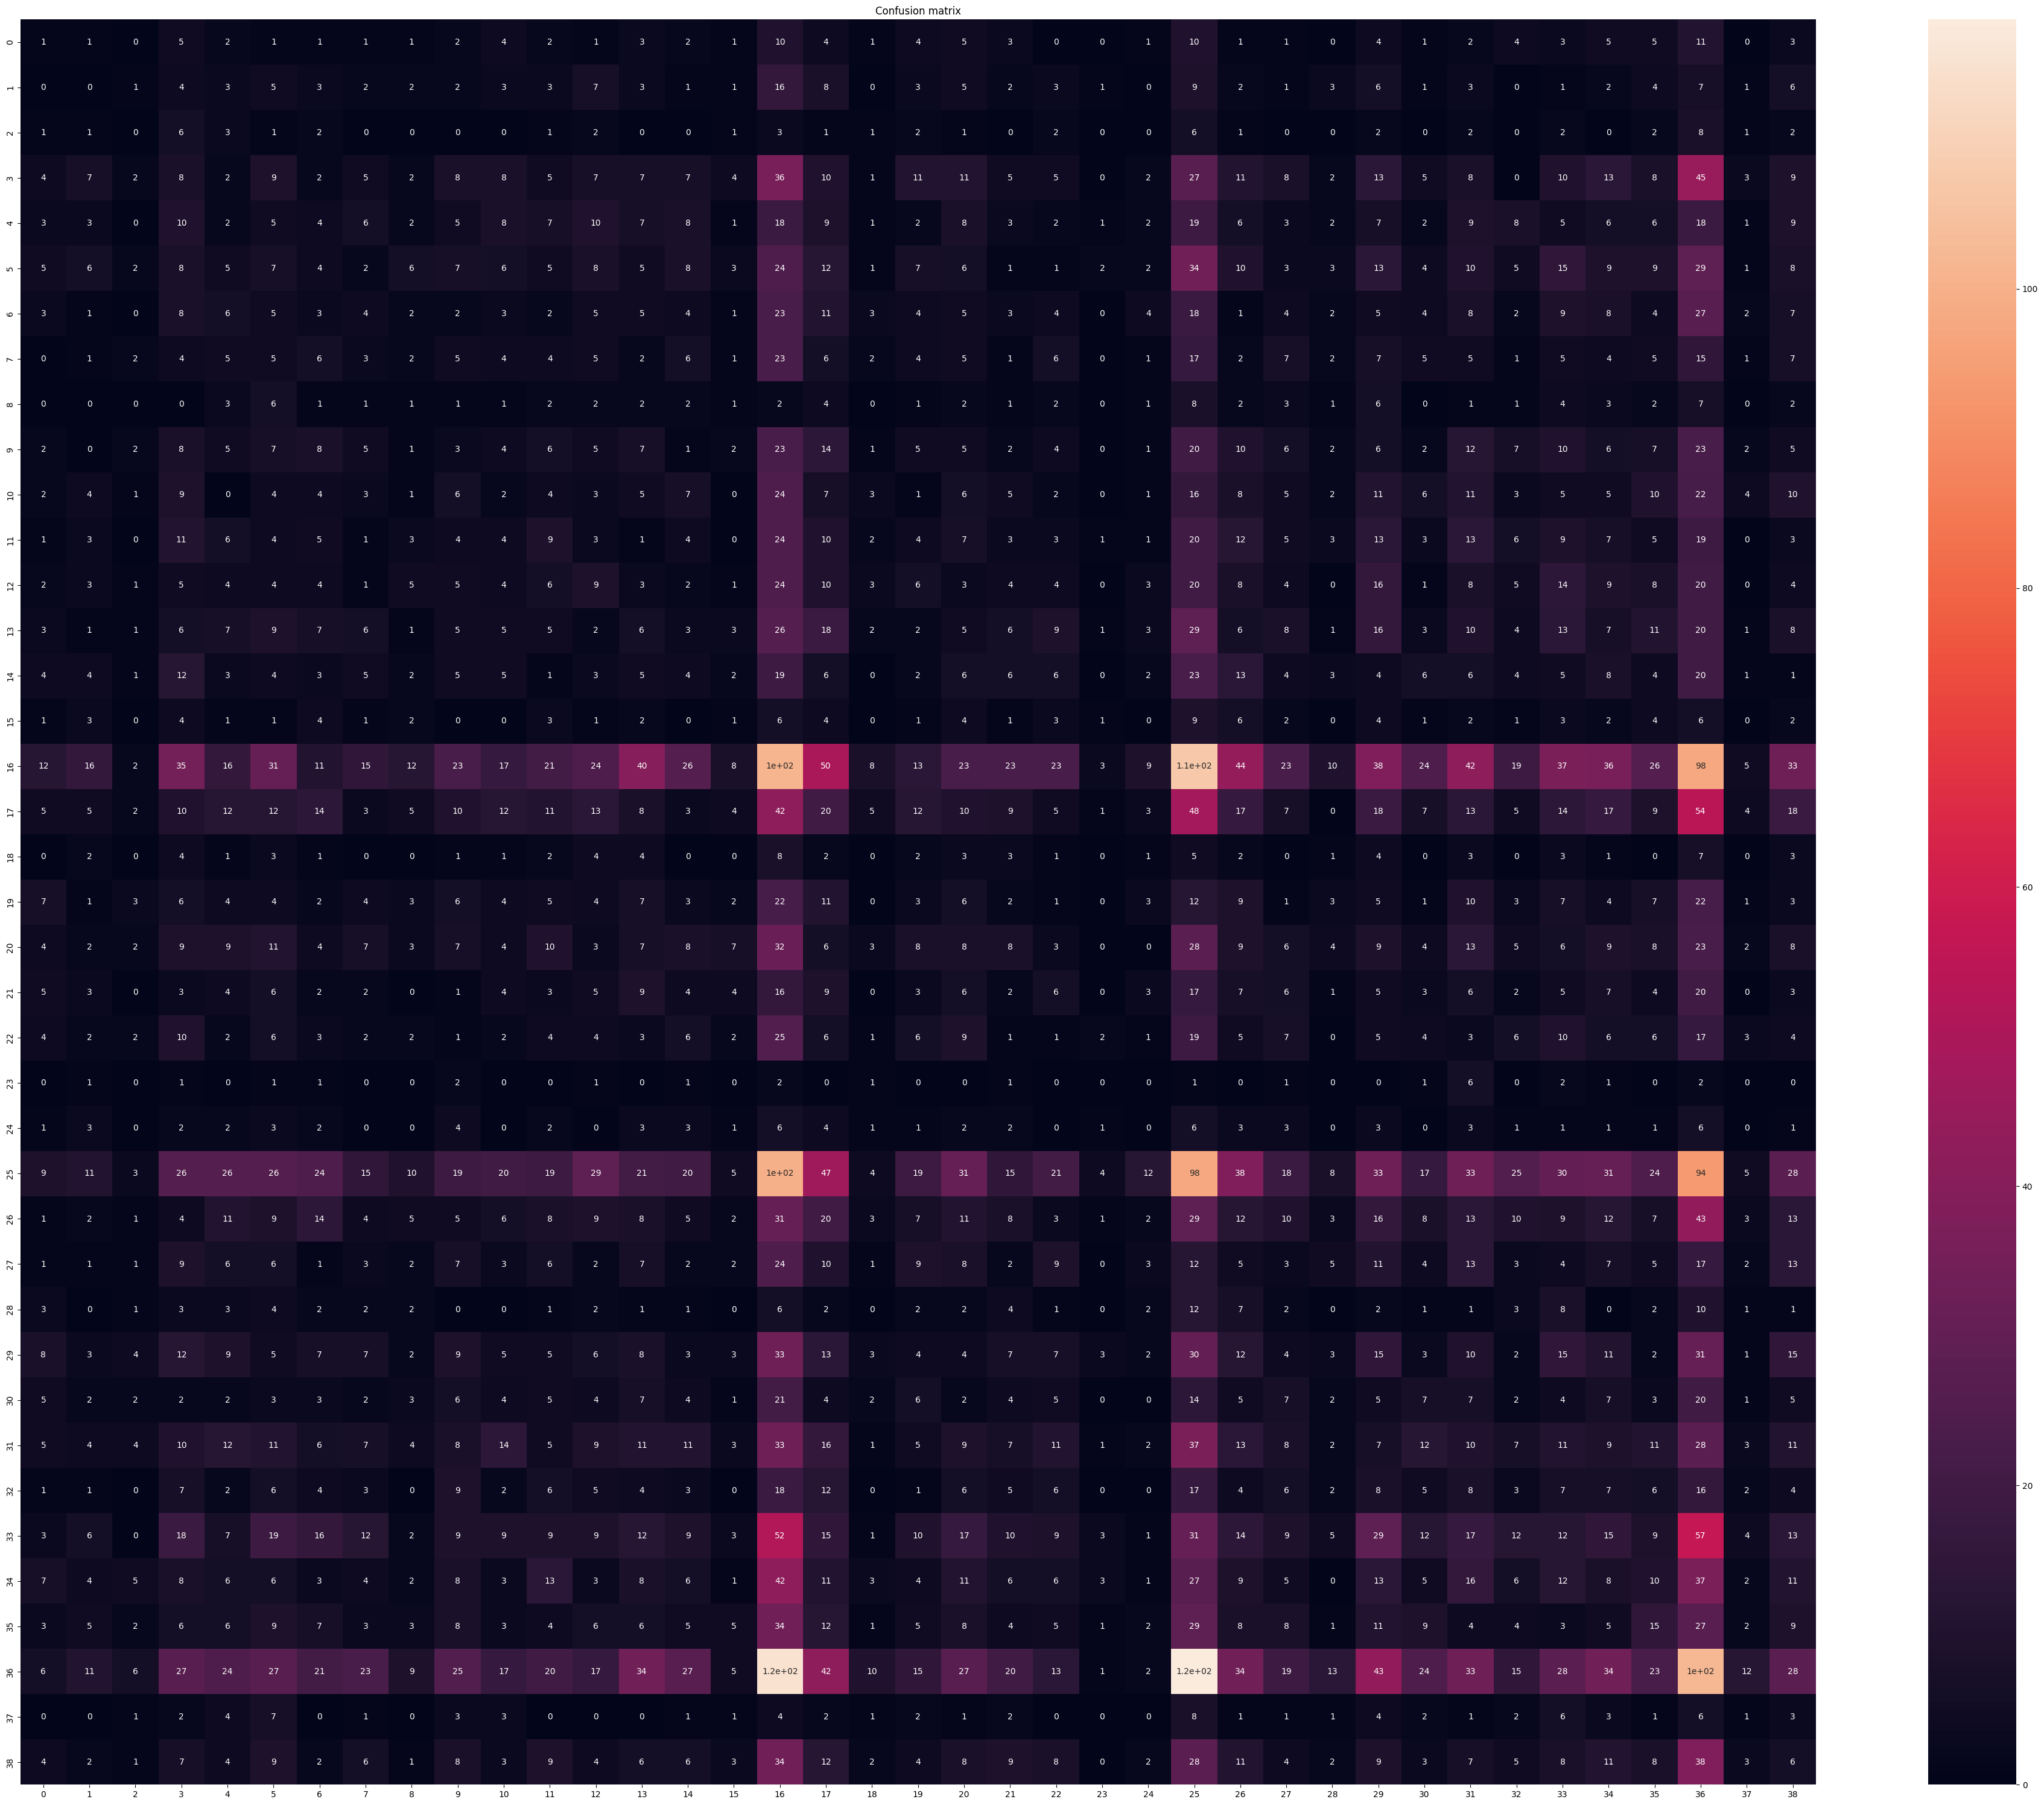

In [52]:
p = model1.predict(val_generator)
p = np.argmax(p, axis=1)
y_true = val_generator.classes
c = confusion_matrix(p, y_true)

plt.figure(figsize=(48,38))
plt.title('Confusion matrix')
sns.heatmap(c, annot=True)
plt.plot()
plt.savefig("model1_Confusion_matrix.png")

In [33]:
model1.save("InceptionResNetV211.h5")

# ***Using MobileNet CNN architecture***

In [7]:
from tensorflow.keras.applications.mobilenet import preprocess_input

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator=train_datagen.flow_from_directory('./output/train',
                                                 target_size=IMG_SIZE,
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
                                                 shuffle=True)

val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator=train_datagen.flow_from_directory('./output/val',
                                                     target_size=IMG_SIZE,
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 44343 images belonging to 39 classes.
Found 11106 images belonging to 39 classes.


In [8]:
base_model=tf.keras.applications.MobileNet(input_shape=IMG_SHAPE, weights='imagenet',include_top=False)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
preds=Dense(39,activation='softmax')(x)

17225924/17225924 [==============================] - 0s 0us/step


In [9]:
model2=Model(inputs=base_model.input,outputs=preds)

In [10]:
for layer in model2.layers[:20]:
    layer.trainable=False
for layer in model2.layers[20:]:
    layer.trainable=True

In [11]:
model2.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=METRICS)

In [12]:
step_size_train=train_generator.n//train_generator.batch_size
model2_history=model2.fit(train_generator,
                    validation_data =val_generator,
                   steps_per_epoch=step_size_train,
                   epochs=5)

Epoch 1/5
1385/1385 [==============================] - 222s 141ms/step - loss: 0.4143 - tp: 37866.0000 - fp: 3161.0000 - tn: 1680657.0000 - fn: 6445.0000 - accuracy: 0.8832 - precision: 0.9230 - recall: 0.8546 - auc: 0.9924 - val_loss: 0.3463 - val_tp: 9903.0000 - val_fp: 681.0000 - val_tn: 421347.0000 - val_fn: 1203.0000 - val_accuracy: 0.9110 - val_precision: 0.9357 - val_recall: 0.8917 - val_auc: 0.9920
Epoch 2/5
1385/1385 [==============================] - 179s 129ms/step - loss: 0.1976 - tp: 41411.0000 - fp: 1862.0000 - tn: 1681956.0000 - fn: 2900.0000 - accuracy: 0.9457 - precision: 0.9570 - recall: 0.9346 - auc: 0.9965 - val_loss: 0.5314 - val_tp: 9128.0000 - val_fp: 1024.0000 - val_tn: 421004.0000 - val_fn: 1978.0000 - val_accuracy: 0.8562 - val_precision: 0.8991 - val_recall: 0.8219 - val_auc: 0.9888
Epoch 3/5
1385/1385 [==============================] - 185s 134ms/step - loss: 0.1577 - tp: 42071.0000 - fp: 1385.0000 - tn: 1682433.0000 - fn: 2240.0000 - accuracy: 0.9593 - prec

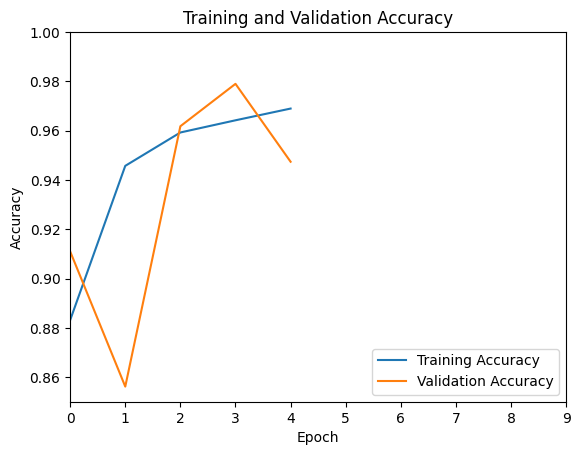

In [20]:
acc = model2_history.history['accuracy']
val_acc = model2_history.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlim([0,9])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.show()

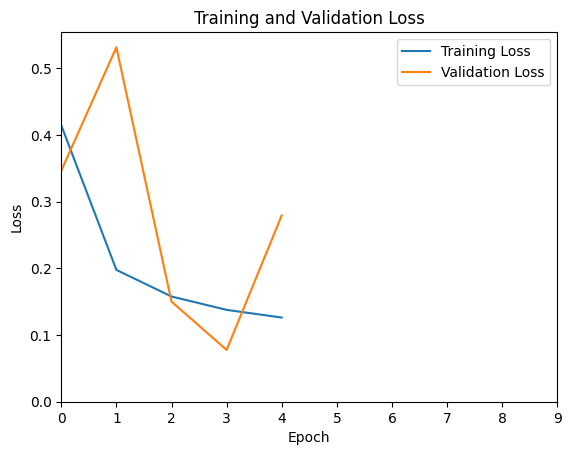

In [14]:
loss = model2_history.history['loss']
val_loss = model2_history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlim([0,9])
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

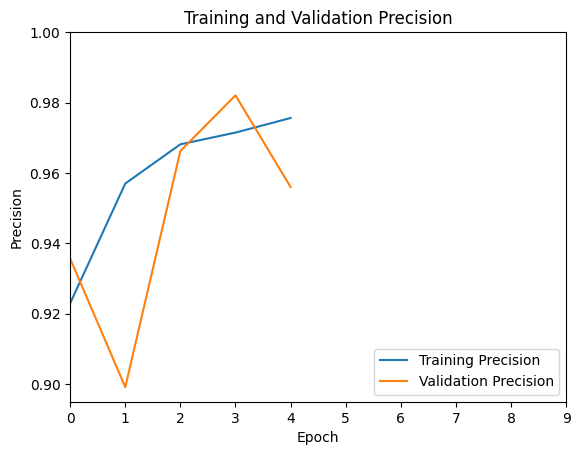

In [15]:
pre = model2_history.history['precision']
val_pre = model2_history.history['val_precision']

plt.plot(pre, label='Training Precision')
plt.plot(val_pre, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel("Precision")
plt.xlim([0,9])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.show()

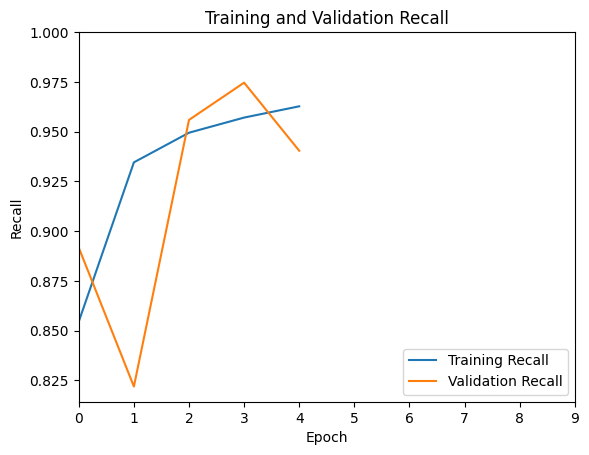

In [16]:
rec = model2_history.history['recall']
val_rec = model2_history.history['val_recall']

plt.plot(rec, label='Training Recall')
plt.plot(val_rec, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel("Recall")
plt.xlim([0,9])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.show()

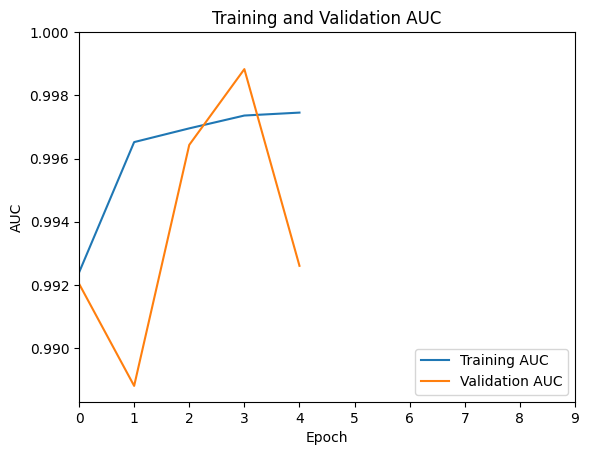

In [17]:
auc = model2_history.history['auc']
val_auc = model2_history.history['val_auc']

plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.ylabel("AUC")
plt.xlim([0,9])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.show()

348/348 [==============================] - 39s 110ms/step


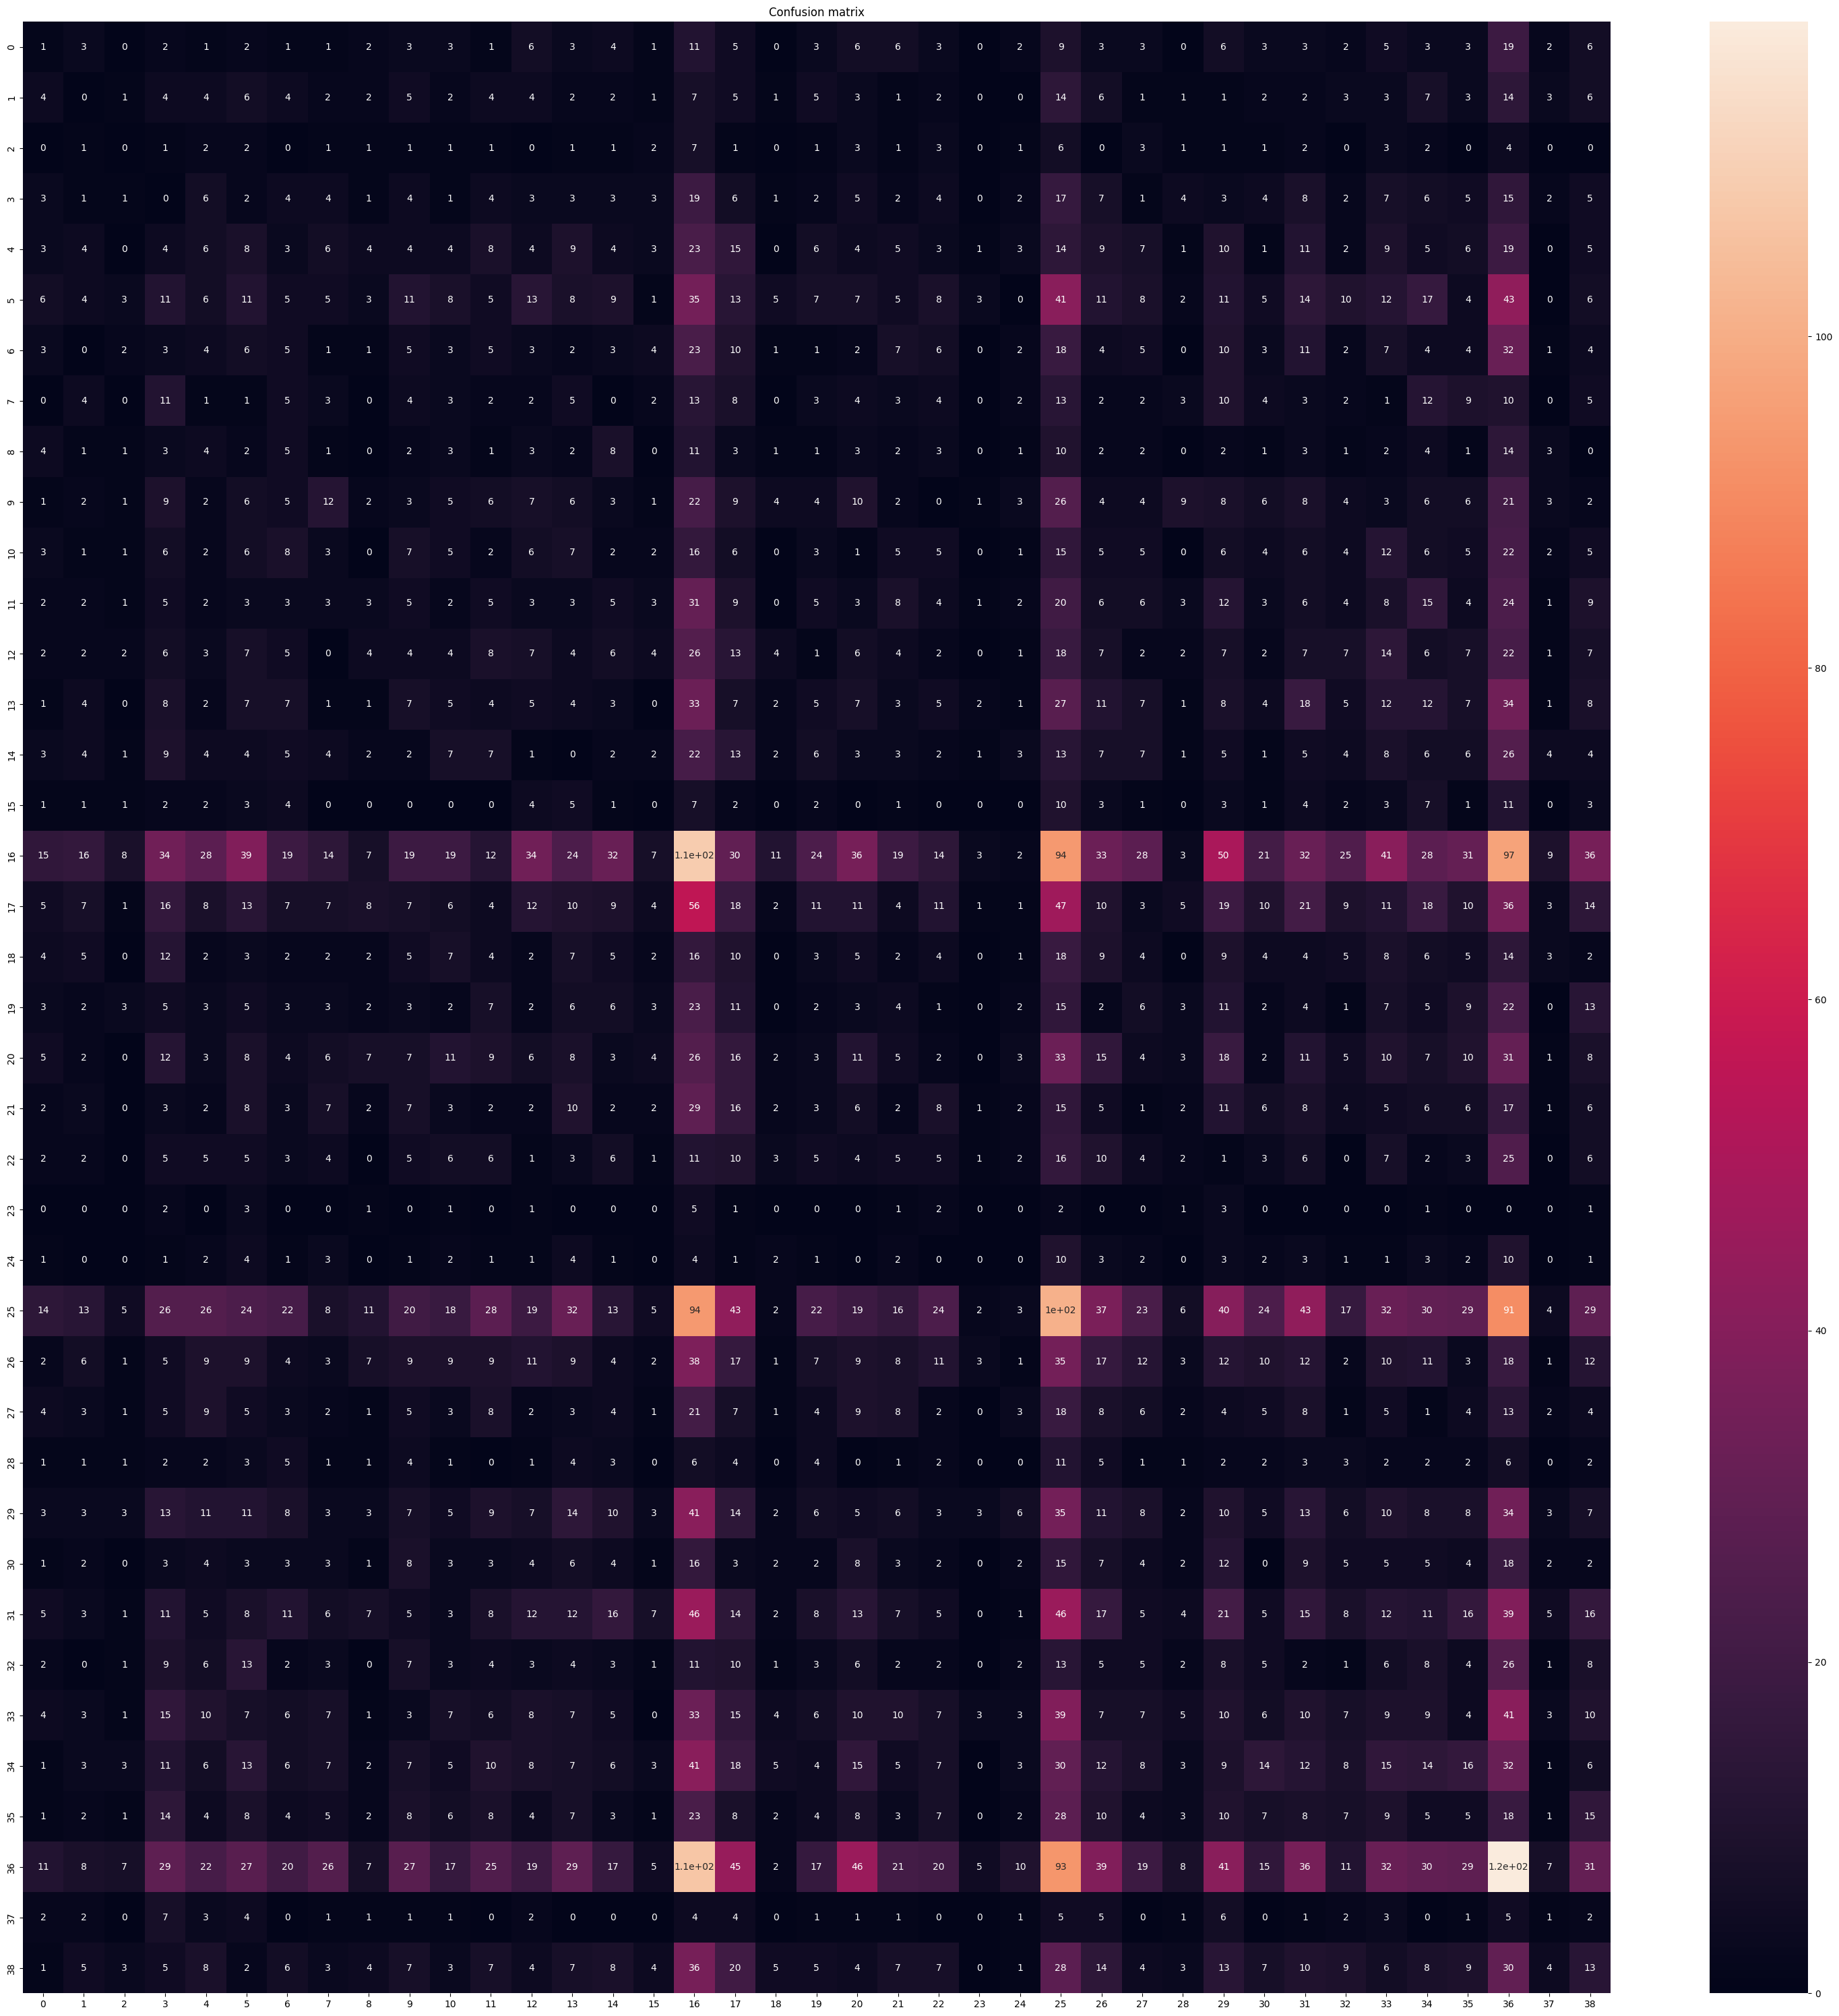

In [18]:
p = model2.predict(val_generator)
p = np.argmax(p, axis=1)
y_true = val_generator.classes
c = confusion_matrix(p, y_true)

plt.figure(figsize=(38,38))
plt.title('Confusion matrix')
sns.heatmap(c, annot=True)
plt.plot()
plt.savefig("model2_Confusion_matrix.png")

In [19]:
model2.save("MobileNet.h5")